# TP 5 Réseaux de neurones - Multi classification et Propagation en arrière
Dans ce TP, nous aimerions entrainer un réseau de neurones pour la tâche de classification en utilisant l'algorithme d propagation en arrière (backpropagation).

L'ensemble de données que nous allons utiliser est le même que celui utilisé durant le TP1, i.e. les images de chiffres manuscrits.


# Importation des librairies necessaires au travail

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
# import cv2 

# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [2]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
data.shape

(5000, 401)

Dans ces données (data), les 400 premières colonnes representent les pixels de l'image (20x20), la dernière colonne represente la classe de l'image (chiffres de 0 à 9). (http://yann.lecun.com/exdb/mnist/)

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [3]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,:-1]))
y=data[:,-1]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [4]:
print('X', X.shape ,' y ', y.shape)

X (5000, 401)  y  (5000, 1)


Visualisation aléatoire de quelques données

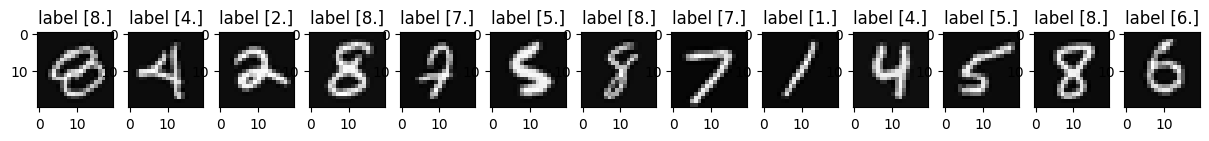

In [5]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,1:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(y[c]))
    plt.imshow(a,cmap='gray')

Transformer y de tel sorte à avoir un vecteur pour chaque exemple

Equivalent de tocategorical

In [6]:
YY=np.zeros((y.shape[0], int(np.max(y))+1))
YY.shape

(5000, 10)

In [7]:
for i in range (YY.shape[0]):
    YY[i,int(y[i])]=1

C:\Users\MELISSA\AppData\Local\Temp\ipykernel_4380\4023512269.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  YY[i,int(y[i])]=1


# Réseaux de neurones
Pour cette partie, nous choisissons une réseau simple:

- une couche d'entrée avec 400 noeuds (20 x 20 pixels) + le biais
- une couche cachée avec 25 noeuds
- une couche de sortie avec 10 noeuds (nombre de classes)

In [8]:
# poids de la couche 1
W1 = np.genfromtxt('W1.csv', delimiter=',', dtype=float)
W1.shape

(25, 401)

In [9]:
# poids de la couche 2
W2 = np.genfromtxt('W2.csv', delimiter=',', dtype=float)
W2.shape

(10, 26)

In [10]:
input_layer_size  = 400
hidden_layer_size = 25   
num_labels = 10

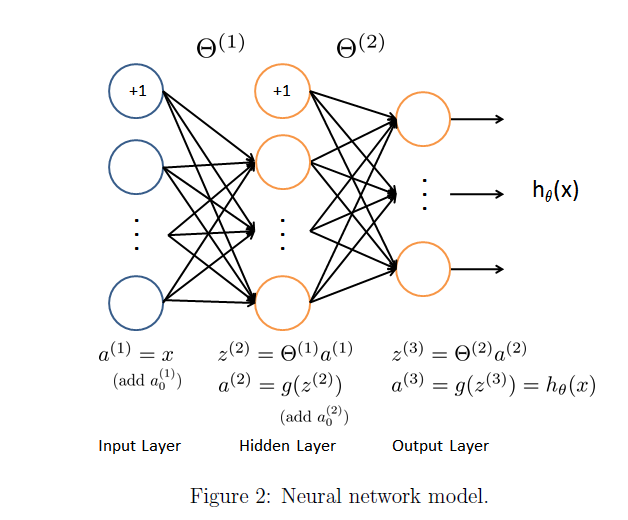

# Calcul du coût

# TODO  1 calcul du coût
**Tâche 1**: Modifier la fonction computeCost afin d'obtenir un coût avec régularisation

Rappelons que le coût avec régularisation est calculé comme suit:

$ J(\theta)= \frac{1}{m} \sum_{i=1}^m\sum_{k=1}^K \left[ -y_k^{(i)} \log (h_\theta(x^{(i)}) )_k - (1-y_k^{(i)}) \log (1-h_\theta(x^{(i)}) )_k \right] + \frac{\lambda}{2m} \left[ \sum_{j=1}^{25}\sum_{k=1}^{400} \left( \theta_{j,k}^{(1)} \right)^2 +   \sum_{j=1}^{10}\sum_{k=1}^{25} \left( \theta_{j,k}^{(2)} \right)^2 \right] $

In [11]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1/(1+np.exp(-z))

In [12]:
def computeCost(X, YY, theta1, theta2,hidden_layer_size, lambda_):
    a1=X; 
    z2= np.zeros((X.shape[0],hidden_layer_size)) 
    a2= np.zeros((X.shape[0],hidden_layer_size)) 

    intercept=np.ones((X.shape[0],1))
    z2=np.column_stack((intercept,np.matmul(a1,np.transpose(theta1))))
    a2=Sigmoid(z2)
    a2[:,0]=1

    z3= np.zeros((YY.shape[0],YY.shape[1]))    
    a3= np.zeros((YY.shape[0],YY.shape[1]))  

    z3=np.matmul(a2,np.transpose(theta2))
    a3=Sigmoid(z3)
    # Regularization part
    second_part = np.sum(np.square(theta1[:,:])) + np.sum(np.square(theta2[:,1:]))
    regularization = (lambda_/(2*YY.shape[0]))*second_part
    J=np.zeros((YY.shape[0],1))
    J= (1/y.shape[0])*(np.sum(np.sum((-YY*np.log(a3))-((1-YY)*np.log(1-a3)))))+regularization

    return J

# TODO  2 calcul du gradient
**Tâche 2**: Implémenter la fonction NNCostFunction afin de retourner:

- Le coût avec régularisation
- Le gardient du coût par rapport à chaqu'un des paramètres du réseau

Rappelons le gradient de la sigmoid:

$ sigmoid(z) =\sigma(z)= \frac{1}{1-e^{-z}}$

$ \sigma(z)^\prime = \sigma(z)(1-\sigma(z)) =a(1-a)$ tel que $a$ est l'activation d'une couche donnée

L'algorithme à implementer est comme suit:

Pour chaque exemple de l'ensemble d'apprentissage faire

Pour chaque noeud de la couche de sortie, calculer la dérivée (gradient):

$\delta_k^{(3)} = \left( a_k^{(3)}- y_k \right)  $

Pour chaque noeud de la couche caché calculer la dérivée (gradient):

$\delta^{(2)} =  \left(\Theta^{(2)}\right)^T \delta^{(3)} \quad .* \quad \sigma^\prime\left(z^{(2)} \right) $

Notons que l'opérateur $.*$ represente la multiplication élement par élement et non pas la multiplication matricielle

Le gradient de chaque noeud et de chaque couche sera finalement:

$\Delta^{(l)} =  \Delta^{(l)} + \delta^{(l)} * \left( a^{(l)} \right)^T $

Fin pour

Fin pour

Diviser le gradient cumulé par le nombre d'exemples:

$ \frac{\partial J(\Theta)} { \partial \Theta_{i,j)}^{(l)}} = \frac{1}{m} \Delta_{(i,j)}^{(l)}$


In [13]:
def SigmoidGradient(z):
    return Sigmoid(z) * (1 - Sigmoid(z))

In [14]:
def NNCostFunction(X, YY, theta1, theta2, hidden_layer_size, lambda_):
    # lambda_ = 0.0
    theta1_grad = np.zeros((theta1.shape[0], theta1.shape[1]))
    theta2_grad = np.zeros((theta2.shape[0], theta2.shape[1]))
    
    # Forward propagation
    a1 = X  # (5000, 401)
    z2 = np.dot(a1, theta1.T)  # (5000, 401) × (25, 401).T → (5000, 25)
    a2 = np.concatenate([np.ones((z2.shape[0], 1)), Sigmoid(z2)], axis=1)  # (5000, 26)
    z3 = np.dot(a2, theta2.T)  # (5000, 26) × (10, 26).T → (5000, 10)
    a3 = Sigmoid(z3)
    
    # Calculate cost
    J = computeCost(X, YY, theta1, theta2, hidden_layer_size, lambda_)
    
    # Backpropagation
    delta3 = a3 - YY  # (5000, 10)
    delta2 = np.dot(delta3, theta2[:, 1:]) * SigmoidGradient(z2)  # (5000,10) × (10,25) → (5000,25)
    theta1_grad = theta1_grad + np.dot(delta2.T, a1) / X.shape[0]  # (25,5000) × (5000,401) → (25,401)
    theta2_grad = theta2_grad + np.dot(delta3.T, a2) / X.shape[0]  # (10,5000) × (5000,26) → (10,26)
    
    grad = np.concatenate([theta1_grad.ravel(), theta2_grad.ravel()])
    return J, grad

In [15]:
J, grad = NNCostFunction(X, YY, W1, W2, hidden_layer_size, 0)
print("J", J)

J 10.441433938769038


# TODO  3 entrainement du réseau
**Tâche 3**: Entrainer le réseau en utilisant la descente du gradient:
Ici il faudra reprendre l'algorithme de la descente du gradient afin de mettre à jour les paramètres du réseau


In [16]:
def gradientDescent(X, y, Theta, alpha, iterations):
   costs = []
   theta1, theta2 = Theta
   for i in range(iterations):
      # Compute cost and gradient
      J, grad = NNCostFunction(X, y, theta1, theta2, hidden_layer_size, lambda_)
      costs.append(J)
      
      # Unroll gradients
      grad1 = grad[:theta1.size].reshape(theta1.shape)
      grad2 = grad[theta1.size:].reshape(theta2.shape)
      
      # Update weights
      theta1 -= alpha * grad1
      theta2 -= alpha * grad2
   
   best_theta1, best_theta2 = theta1, theta2
   return best_theta1, best_theta2, costs

In [17]:
iterations = 800
lambda_ = 1.0
alpha = 0.8
theta1 = W1
theta2 = W2
#appel descente du gradient non régularisé et affichage de la courbe du cout
theta1, theta2, costs = gradientDescent(X, YY, (theta1, theta2), alpha, iterations)


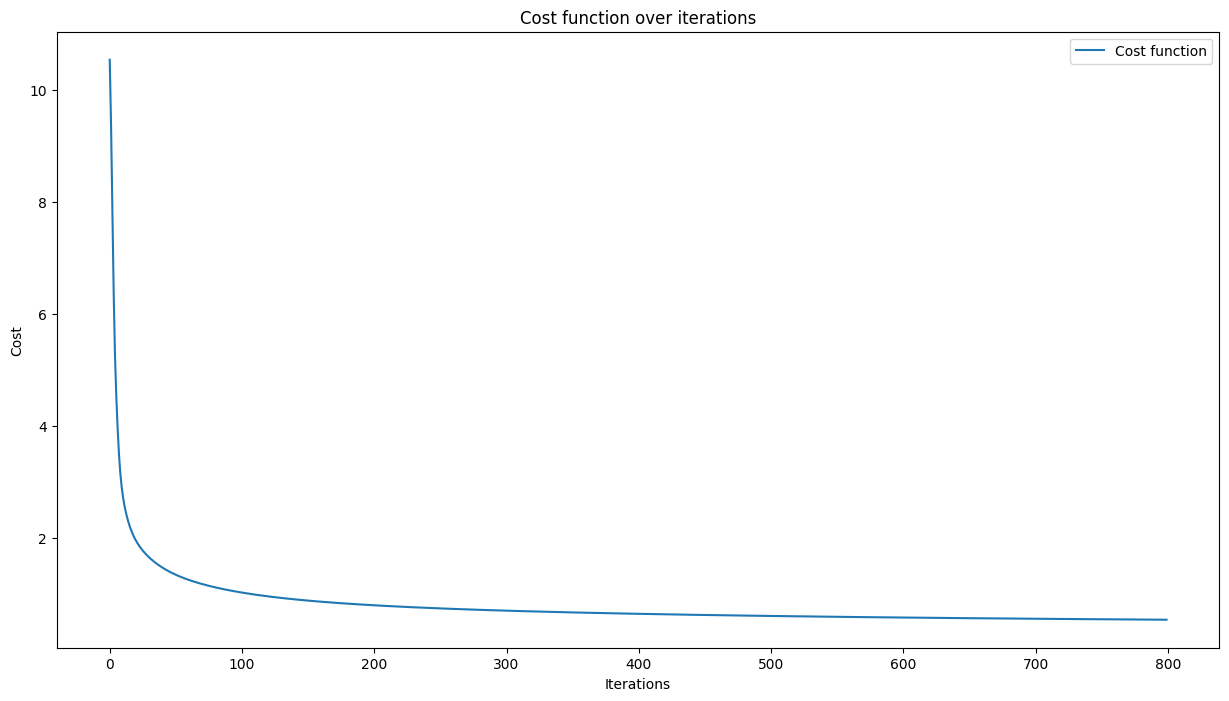

In [18]:
plt.figure(figsize=(15,8))
plt.plot(costs, label='Cost function')
plt.title('Cost function over iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()

In [19]:
costs[-1]

0.5350667683441883

# TODO 4 : Régularisation
Mettre à jour le calcul du coût en ajoutant le terme de régularisation et comparer les résultats (avec et sans régularisation)

In [20]:
def gradientDescentRegularization(X, y, Theta, alpha, iterations, lambda_):
   costs = []
   theta1, theta2 = Theta
   for i in range(iterations):
      # Compute cost and gradient
      J, grad = NNCostFunction(X, y, theta1, theta2, hidden_layer_size, lambda_)
      costs.append(J)
      
      # Unroll gradients
      grad1 = grad[:theta1.size].reshape(theta1.shape)
      grad2 = grad[theta1.size:].reshape(theta2.shape)
      if(lambda_ > 0):
            # Regularization
            grad1[:, 1:] += (lambda_ / X.shape[0]) * theta1[:, 1:]
            grad2[:, 1:] += (lambda_ / X.shape[0]) * theta2[:, 1:]
      # Update weights
      theta1 -= alpha * grad1
      theta2 -= alpha * grad2
   
   best_theta1, best_theta2 = theta1, theta2
   return best_theta1, best_theta2, costs

In [21]:
iterations = 800
lambda_ = 1.0
alpha = 0.8
theta1 = W1
theta2 = W2
#appel descente du gradient régularisé et affichage de la courbe du cout
theta1, theta2, costs = gradientDescentRegularization(X, YY, (theta1, theta2), alpha, iterations, lambda_)

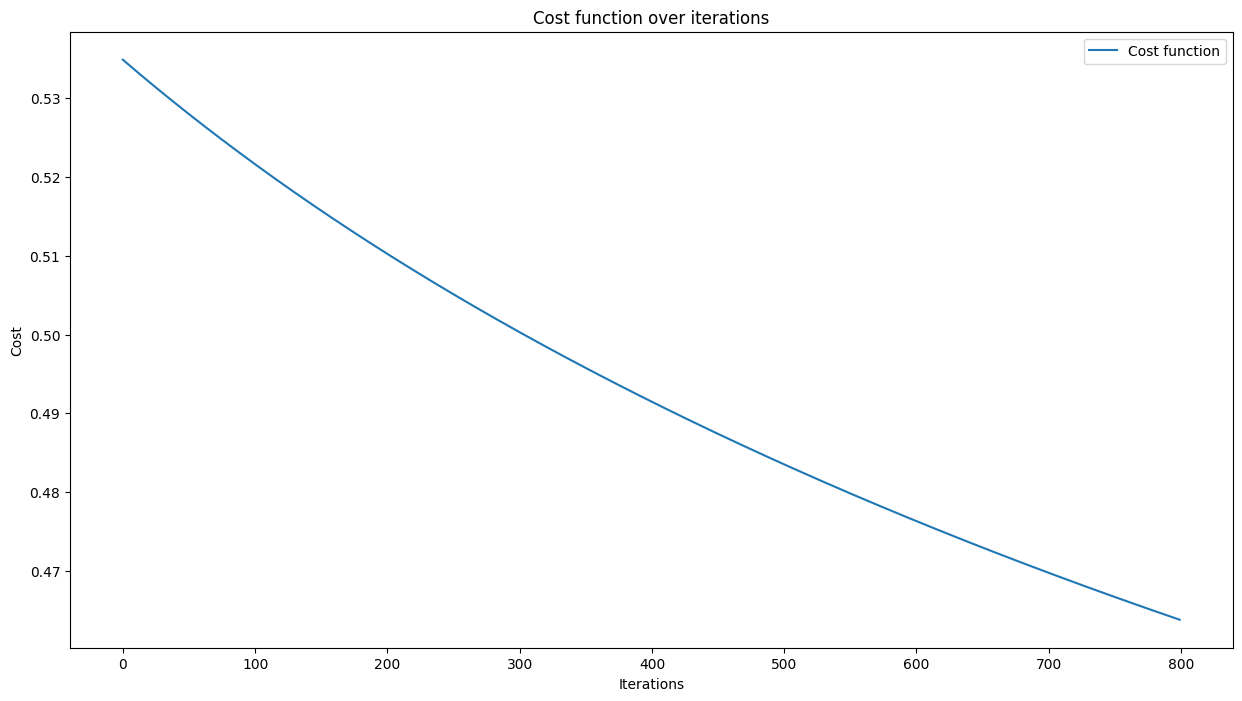

In [22]:
plt.figure(figsize=(15,8))
plt.plot(costs, label='Cost function')
plt.title('Cost function over iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()

In [23]:
costs[-1]

0.46378078365061237

# TODO 5 : Prédiction

Appliquer une propagation en avant en utilisant les paramètres données pour prédir les classes de l'ensemble d'apprentissage.



Dans ce cas on doit utiliser une fonction d'activation probabiliste qui est le softmax

In [24]:
def predict (W1, W2, X):
    
    # appliquer une propagation en avant
    # !--- n'oubliez pas d'appliquer la sigmoid à chaque couche afin d'avoir les probabilités ---!
    # prédire la classe en choisissant la probabilité maximale parmi les 10 noeuds de sortie
    # Forward propagation
    z2 = np.dot(X, W1.T)
    a2 = np.concatenate([np.ones((z2.shape[0], 1)), Sigmoid(z2)], axis=1)
    z3 = np.dot(a2, W2.T)
    a3 = Sigmoid(z3)
    
    # Predict the class with the highest probability
    y_pred = np.argmax(a3, axis=1).reshape(-1, 1)
    return y_pred

In [25]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
# theta1, theta2, J = gradientDescentRegularization(X, YY, (W1, W2), alpha, iterations, lambda_)
y_pred=predict(theta1,theta2,X)
precision = np.mean(y==y_pred)*100
precision

96.7

# Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import time

hidden_size = 25
output_size = 10
lambda_ = 0.1
iterations = 500

start_time = time.time()
theta1, theta2, costs = gradientDescentRegularization(
    X, YY, (theta1, theta2), alpha, iterations, lambda_
)
custom_time = time.time() - start_time

# Prédiction
y_pred_custom = predict(theta1, theta2, X)


# scikit-learn implémentation ----------------------------------------------
start_time = time.time()
mlp = MLPClassifier(
    hidden_layer_sizes=(hidden_size,),
    activation='logistic',
    solver='sgd',
    learning_rate_init=alpha,
    alpha=lambda_,
    max_iter=iterations,
    batch_size= X.shape[0],
    random_state=42,
    early_stopping=False
)

mlp.fit(X[:, 1:], y)  # On retire le biais ajouté manuellement
sklearn_time = time.time() - start_time

y_pred_sklearn = mlp.predict(X[:, 1:])


# Affichage des résultats -----------------------------------------------
print("Custom model")
print(f"Custom implementation time: {custom_time:.4f} seconds")
print(classification_report(
    y, 
    y_pred_custom,
    target_names=[f"Classe {i}" for i in range(YY.shape[1])]
))

print("Sklearn model")
print(f"Scikit-learn implementation time: {sklearn_time:.4f} seconds")
print(classification_report(
    y, 
    y_pred_sklearn,
    target_names=[f"Classe {i}" for i in range(YY.shape[1])]
))



C:\Users\MELISSA\AppData\Roaming\Python\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Custom model
Custom implementation time: 11.7546 seconds
              precision    recall  f1-score   support

    Classe 0       1.00      1.00      1.00       500
    Classe 1       1.00      1.00      1.00       500
    Classe 2       1.00      0.99      0.99       500
    Classe 3       0.99      0.99      0.99       500
    Classe 4       1.00      1.00      1.00       500
    Classe 5       1.00      1.00      1.00       500
    Classe 6       1.00      1.00      1.00       500
    Classe 7       0.99      0.99      0.99       500
    Classe 8       1.00      1.00      1.00       500
    Classe 9       0.99      0.99      0.99       500

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000

Sklearn model
Scikit-learn implementation time: 12.9120 seconds
              precision    recall  f1-score   support

    Classe 0       1.00      1.00      1.00       500
    Classe 

# Optionnel : Renforcement de l'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

- Augmentation des données : Créez de nouvelles variations des données en appliquant des transformations.
- Optimisation des hyperparamètres : Trouvez les meilleurs paramètres pour votre modèle en expérimentant avec différentes valeurs.
- Utilisation d'algorithmes avancés : Explorez des modèles plus complexes adaptés à vos données, comme les réseaux de neurones convolutionnels ou récurrents.
- Ensemble Learning : Améliorez les performances en combinant les prédictions de plusieurs modèles.
- Validation croisée : Évaluez la performance de manière fiable en utilisant la validation croisée.
- Analyse des erreurs : Comprenez les faiblesses du modèle en analysant les prédictions incorrectes.
- Réduction de la dimensionnalité : Réduisez le nombre de caractéristiques tout en préservant les informations importantes.
- Interprétabilité du modèle : Analysez le comportement du modèle pour comprendre ses prédictions.